<div align="center"><a href="https://www.nvidia.com/en-us/deep-learning-ai/education/"><img src="./assets/DLI_Header.png"></a></div>

# Deploying a Model for Inference at Production Scale

## 05 - Simple TensorRT Model
-------

**Table of Contents**

* [Introduction](#introduction)
* [TensorRT - Programmable Inference Accelerator](#tensorrt)
* [Create Model Directory Structure](#structure)
* [Convert ONNX to TensorRT](#model)
* [Create Configuration File](#configuration)
* [Load Model in Triton Inference Server](#load)
* [Send Inference Request to Server](#infer)
* [Exercise](#exercise)
* [Conclusion](#conclusion)


<a id="introduction"></a>
### Introduction

In this notebook, we will take our previously created ONNX model and convert it to a TensorRT representation to be deployed in Triton Inference Server. TensorRT is a highly optimized package that takes trained models and optimizes them for inference. We'll see how to create model directory structures and configuration files within Triton Inference Server, how to work with `trtexec`, and how to send inference requests to the models deployed within Triton Inference Server.

<a id="tensorrt"></a>
### TensorRT - Programmable Inference Accelerator

NVIDIA TensorRT™ is a platform for high-performance deep learning inference. It includes a deep learning inference optimizer and runtime that delivers low latency and high-throughput for deep learning inference applications. TensorRT-based applications perform up to 40x faster than CPU-only platforms during inference. 

With TensorRT, you can optimize neural network models trained in all major frameworks, calibrate for lower precision with high accuracy, and finally deploy to hyperscale data centers, embedded, or automotive product platforms.

Here are some great resources for getting started on TensorRT:
 
* Main Page: https://developer.nvidia.com/tensorrt
* Blogs: https://devblogs.nvidia.com/speed-up-inference-tensorrt/
* Download: https://developer.nvidia.com/nvidia-tensorrt-download
* Documentation: https://docs.nvidia.com/deeplearning/sdk/tensorrt-developer-guide/index.html
* Sample Code: https://docs.nvidia.com/deeplearning/sdk/tensorrt-sample-support-guide/index.html
* GitHub: https://github.com/NVIDIA/TensorRT
* NGC Container: https://ngc.nvidia.com/catalog/containers/nvidia:tensorrt

<a id="structure"></a>
### Create Model Directory Structure

Triton Inference Server serves models within a model repository. When you first run Triton Inference Server, you'll specify the model repository where the models reside:

```
tritonserver --model-repository=/models
```

Each model resides in its own model subdirectory within the model repository - i.e. each directory within `/models` represents a unique model. For example, in this notebook we'll be deploying two TensorRT models in the `simple-tensorrt-fp32-model` and `simple-tensorrt-fp16-model`, where one model is optimized to use FP32 data types and the other is optimized to use FP16 data types. 

All models typically follow a similar directory structure. Within each of these directories, we'll create a configuration file `config.pbtxt` that details information about the model - e.g. batch size, input shapes, deployment backend (PyTorch, ONNX, TensorFlow, TensorRT, etc.) and more. We'll explore the configuration file later in this notebook.

Additionally, we can create one or more versions of our model. Each version lives under a subdirectory names with the respective version number, starting with `1`. It is within this subdirectory where our model files reside (e.g. `model.plan`).

```
root@server:/models$ tree
.
└── simple-tensorrt-model
    ├── 1
    │   └── model.plan
    └── config.pbtxt

```

We can also add a file representing the names of the outputs. We have omitted this step in this notebook for the sake of brevity. For more details on how to work with model repositories and model directory structures in Triton Inference Server, please see the documentation here: https://github.com/triton-inference-server/server/blob/r20.12/docs/model_repository.md

Below, we'll create the model directory structure for each of our TensorRT models.

In [1]:
!mkdir -p models/simple-tensorrt-fp32-model/
!mkdir -p models/simple-tensorrt-fp32-model/1/
!mkdir -p models/simple-tensorrt-fp16-model/
!mkdir -p models/simple-tensorrt-fp16-model/1/

<a id="model"></a>
### Convert ONNX to TensorRT

In the previous [02_Simple_PyTorch_Model.ipynb](02_Simple_PyTorch_Model.ipynb) notebook, we created an ONNX representation of our ResNet50 model and saved it as as `model.onnx` file (If you are returning to this notebook after the time for a previous session has expired, please rerun notebook 02). In this section, we'll take that ONNX representation and convert it to a TensorRT plan using the `trtexec` command line utility. `trtexec` is easy to use and more details on installation and documentation can be found here: https://github.com/NVIDIA/TensorRT/tree/master/samples/trtexec

To learn more about the `trtexec` command, uncomment and execute the cell below (warning it's quite verbose).

In [5]:
 #!trtexec

In [2]:
!trtexec \
  --onnx=models/simple-onnx-model/1/model.onnx \
  --explicitBatch \
  --optShapes=actual_input_1:16x3x224x224 \
  --maxShapes=actual_input_1:32x3x224x224 \
  --minShapes=actual_input_1:1x3x224x224 \
  --shapes=actual_input_1:1x3x224x224 \
  --saveEngine=models/simple-tensorrt-fp32-model/1/model.plan


&&&& RUNNING TensorRT.trtexec # trtexec --onnx=models/simple-onnx-model/1/model.onnx --explicitBatch --optShapes=actual_input_1:16x3x224x224 --maxShapes=actual_input_1:32x3x224x224 --minShapes=actual_input_1:1x3x224x224 --shapes=actual_input_1:1x3x224x224 --saveEngine=models/simple-tensorrt-fp32-model/1/model.plan
[03/05/2023-22:31:05] [I] === Model Options ===
[03/05/2023-22:31:05] [I] Format: ONNX
[03/05/2023-22:31:05] [I] Model: models/simple-onnx-model/1/model.onnx
[03/05/2023-22:31:05] [I] Output:
[03/05/2023-22:31:05] [I] === Build Options ===
[03/05/2023-22:31:05] [I] Max batch: explicit
[03/05/2023-22:31:05] [I] Workspace: 16 MiB
[03/05/2023-22:31:05] [I] minTiming: 1
[03/05/2023-22:31:05] [I] avgTiming: 8
[03/05/2023-22:31:05] [I] Precision: FP32
[03/05/2023-22:31:05] [I] Calibration: 
[03/05/2023-22:31:05] [I] Refit: Disabled
[03/05/2023-22:31:05] [I] Safe mode: Disabled
[03/05/2023-22:31:05] [I] Save engine: models/simple-tensorrt-fp32-model/1/model.plan
[03/05/2023-22:31:05

To convert our ONNX representation to a TensorRT plan, we'll point to our `model.onnx` file and specify the output for our newly created TensorRT plan. It's as simple as that!

By adding the `--fp16` flag, we can specify that our TensorRT plan will be optimized for FP16. There are a lot of benefits to using FP16, mainly of which is that it is faster (fewer computations) and uses less memory.

In [4]:
!trtexec \
  --onnx=models/simple-onnx-model/1/model.onnx \
  --explicitBatch \
  --optShapes=actual_input_1:16x3x224x224 \
  --maxShapes=actual_input_1:32x3x224x224 \
  --minShapes=actual_input_1:1x3x224x224 \
  --shapes=actual_input_1:1x3x224x224 \
  --saveEngine=models/simple-tensorrt-fp16-model/1/model.plan \
  --fp16


&&&& RUNNING TensorRT.trtexec # trtexec --onnx=models/simple-onnx-model/1/model.onnx --explicitBatch --optShapes=actual_input_1:16x3x224x224 --maxShapes=actual_input_1:32x3x224x224 --minShapes=actual_input_1:1x3x224x224 --shapes=actual_input_1:1x3x224x224 --saveEngine=models/simple-tensorrt-fp16-model/1/model.plan --fp16
[03/05/2023-22:34:55] [I] === Model Options ===
[03/05/2023-22:34:55] [I] Format: ONNX
[03/05/2023-22:34:55] [I] Model: models/simple-onnx-model/1/model.onnx
[03/05/2023-22:34:55] [I] Output:
[03/05/2023-22:34:55] [I] === Build Options ===
[03/05/2023-22:34:55] [I] Max batch: explicit
[03/05/2023-22:34:55] [I] Workspace: 16 MiB
[03/05/2023-22:34:55] [I] minTiming: 1
[03/05/2023-22:34:55] [I] avgTiming: 8
[03/05/2023-22:34:55] [I] Precision: FP32+FP16
[03/05/2023-22:34:55] [I] Calibration: 
[03/05/2023-22:34:55] [I] Refit: Disabled
[03/05/2023-22:34:55] [I] Safe mode: Disabled
[03/05/2023-22:34:55] [I] Save engine: models/simple-tensorrt-fp16-model/1/model.plan
[03/05/2

<a id="configuration"></a>
### Create Configuration File

With our models defined and written out in TensorRT plan representations, we now turn our attention to creating configuration files for our models.

A minimal model configuration must specify the name of the model, the platform and/or backend properties, the max_batch_size property, and the input and output tensors of the model (name, data type, and shape).

For more details on how to create model configuration files within Triton Inference Server, please see the documentation: 
https://github.com/triton-inference-server/server/blob/r20.12/docs/model_configuration.md

In [6]:
configuration = """
name: "simple-tensorrt-fp32-model"
platform: "tensorrt_plan"
max_batch_size: 32
input [
 {
    name: "actual_input_1"
    data_type: TYPE_FP32
    format: FORMAT_NCHW
    dims: [ 3, 224, 224 ]
  }
]
output {
    name: "output1"
    data_type: TYPE_FP32
    dims: [ 1000 ]
  }
"""

with open('models/simple-tensorrt-fp32-model/config.pbtxt', 'w') as file:
    file.write(configuration)

We'll also create a configuration file for the TensorRT Fp16 model. Note that our input and output data types still remain in their FP32 representation - the internal layers and activations of our neural network will use the FP16 data type but our input and output data will still be in FP32.

In [7]:
configuration = """
name: "simple-tensorrt-fp16-model"
platform: "tensorrt_plan"
max_batch_size: 32
input [
 {
    name: "actual_input_1"
    data_type: TYPE_FP32
    format: FORMAT_NCHW
    dims: [ 3, 224, 224 ]
  }
]
output {
    name: "output1"
    data_type: TYPE_FP32
    dims: [ 1000 ]
  }
"""

with open('models/simple-tensorrt-fp16-model/config.pbtxt', 'w') as file:
    file.write(configuration)

<a id="load"></a>
### Load Model in Triton Inference Server


With our model directory structures created, models defined and exported, and configuration files created, we will now wait for Triton Inference Server to load our models. We have set up this lab to use Triton Inference Server in **polling** mode. This means that Triton Inference Server will continuously poll for modifications to our models or for newly created models - once every 30 seconds. Please run the cell below to allow time for Triton Inference Server to poll for new models/modifications before proceeding.

In [8]:
!sleep 45

At this point, our models should be deployed and ready to use! To confirm Triton Inference Server is up and running, we can see a `curl` request to the below URL.

In [9]:
!curl -v triton:8000/v2/health/ready

*   Trying 172.18.0.3:8000...
* TCP_NODELAY set
* Connected to triton (172.18.0.3) port 8000 (#0)
> GET /v2/health/ready HTTP/1.1
> Host: triton:8000
> User-Agent: curl/7.68.0
> Accept: */*
> 
* Mark bundle as not supporting multiuse
< HTTP/1.1 200 OK
< Content-Length: 0
< Content-Type: text/plain
< 
* Connection #0 to host triton left intact


The HTTP request returns status 200 if Triton is ready and non-200 if it is not ready.

We can also send a `curl` request to our model endpoints to confirm our models are deployed and ready to use. This `curl` request returns status 200 if the model is ready and non-200 if it is not ready. 

Additionally, we will also see information about our models such:

* The name of our model,
* The versions available for our model,
* The backend platform (e.g. tensorrt_plan), 
* The inputs and outputs, with their respective names, data types, and shapes.


In [10]:
!curl -v triton:8000/v2/models/simple-tensorrt-fp32-model

*   Trying 172.18.0.3:8000...
* TCP_NODELAY set
* Connected to triton (172.18.0.3) port 8000 (#0)
> GET /v2/models/simple-tensorrt-fp32-model HTTP/1.1
> Host: triton:8000
> User-Agent: curl/7.68.0
> Accept: */*
> 
* Mark bundle as not supporting multiuse
< HTTP/1.1 200 OK
< Content-Type: application/json
< Content-Length: 226
< 
* Connection #0 to host triton left intact
{"name":"simple-tensorrt-fp32-model","versions":["1"],"platform":"tensorrt_plan","inputs":[{"name":"actual_input_1","datatype":"FP32","shape":[-1,3,224,224]}],"outputs":[{"name":"output1","datatype":"FP32","shape":[-1,1000]}]}

In [11]:
!curl -v triton:8000/v2/models/simple-tensorrt-fp16-model

*   Trying 172.18.0.3:8000...
* TCP_NODELAY set
* Connected to triton (172.18.0.3) port 8000 (#0)
> GET /v2/models/simple-tensorrt-fp16-model HTTP/1.1
> Host: triton:8000
> User-Agent: curl/7.68.0
> Accept: */*
> 
* Mark bundle as not supporting multiuse
< HTTP/1.1 200 OK
< Content-Type: application/json
< Content-Length: 226
< 
* Connection #0 to host triton left intact
{"name":"simple-tensorrt-fp16-model","versions":["1"],"platform":"tensorrt_plan","inputs":[{"name":"actual_input_1","datatype":"FP32","shape":[-1,3,224,224]}],"outputs":[{"name":"output1","datatype":"FP32","shape":[-1,1000]}]}

<a id="infer"></a>
### Send Inference Request to Server

With our models deployed, it is now time to send inference requests to our models. 

First, we'll load the `tritonclient.http` module and a utility function for working with NumPy data.


In [12]:
import tritonclient.http as tritonhttpclient
from tritonclient.utils import triton_to_np_dtype

Next, we'll load our ImageNet input labels, our image of our goldfish, and some helper functions from TensorFlow Keras for loading the image, resizing the image, preprocessing the input, and decoding the predictions. 

In [13]:
import json

with open('./imagenet-simple-labels.json') as file:
    labels = json.load(file)

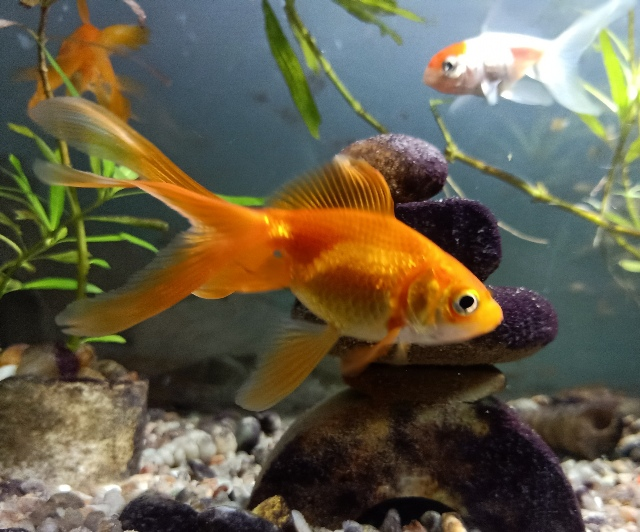

In [14]:
import numpy as np
from PIL import Image


img_path = './assets/goldfish.jpg'
image_pil = Image.open(img_path)
image_pil

In [17]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np


img = image.load_img(img_path, target_size=(224, 224))
image_numpy = image.img_to_array(img)
image_numpy = np.expand_dims(image_numpy, axis=0)
image_numpy = preprocess_input(image_numpy)
image_numpy = np.transpose(image_numpy, [0, 3, 1, 2]) / 255.
print(image_numpy.shape)

(1, 3, 224, 224)


Next, we'll define the input and output names of our model, the name of our model, the URL where our models are deployed with Triton Inference Server (in this case local host of `triton:8000`), and our model version.

In [18]:
VERBOSE = False
input_name = 'actual_input_1'
output_name = 'output1'
model_name = 'simple-tensorrt-fp32-model'
url = 'triton:8000'
model_version = '1'

We'll instantiate our client `triton_client` using the `tritonhttpclient.InferenceServerClient` class access the model metadata with the `.get_model_metadata()` method as well as get our model configuration with the `get_model_config()` method.

In [19]:
triton_client = tritonhttpclient.InferenceServerClient(url=url, verbose=VERBOSE)
model_metadata = triton_client.get_model_metadata(model_name=model_name, model_version=model_version)
model_config = triton_client.get_model_config(model_name=model_name, model_version=model_version)

We'll instantiate a placeholder for our input data using the input name, shape, and data type expected. We'll set the data of the input to be the NumPy array representation of our goldfish image. We'll also instantiate a placeholder for our output data using just the output name.

Lastly, we'll submit our input to the Triton Inference Server using the `triton_client.infer()` method, specifying our model name, model version, inputs, and outputs and convert our result to a NumPy array.

In [20]:
input0 = tritonhttpclient.InferInput(input_name, (1, 3, 224, 224), 'FP32')
input0.set_data_from_numpy(image_numpy, binary_data=False)

output = tritonhttpclient.InferRequestedOutput(output_name, binary_data=False)
response = triton_client.infer(model_name, model_version=model_version, 
                               inputs=[input0], outputs=[output])
logits = response.as_numpy('output1')
logits = np.asarray(logits, dtype=np.float32)

And that's all there is to it! We can identify the largest logit value and confirm that our model correctly inferred that our image is, indeed, a goldfish.

In [21]:
print(labels[np.argmax(logits)])

goldfish


<a id="exercise"></a>
### Exercise #2 - Submit an Inference Request to the TensorRT FP16 model

We leave it as an exercise for the participant to submit an inference to the deployed TensorRT Fp16 model. If you get stuck (or want to confirm your answer),  click the `...` to reveal the answer.

#### Step 1: Define names and shapes

**Hint**: Try looking at the TensorRT Fp16 `configuration` defined above.

In [22]:
VERBOSE = False
input_name = 'actual_input_1'
input_shape = (1, 3, 224, 224)
input_dtype = 'FP32'
output_name = 'output1'
model_name = 'simple-tensorrt-fp16-model'
url = 'triton:8000'
model_version = '1'

In [ ]:
VERBOSE = False
input_name = 'actual_input_1'
input_shape = (1, 3, 224, 224)
input_dtype = 'FP32'
output_name = 'output1'
model_name = 'simple-tensorrt-fp16-model'
url = 'triton:8000'
model_version = '1'

#### Step 2: Get model information from Triton

In [23]:
triton_client = tritonhttpclient.InferenceServerClient(url=url, verbose=VERBOSE)
model_metadata = triton_client.get_model_metadata(model_name=model_name, model_version=model_version)
model_config = triton_client.get_model_config(model_name=model_name, model_version=model_version)

In [ ]:
triton_client = tritonhttpclient.InferenceServerClient(url=url, verbose=VERBOSE)
model_metadata = triton_client.get_model_metadata(model_name=model_name, model_version=model_version)
model_config = triton_client.get_model_config(model_name=model_name, model_version=model_version)

#### Step 3: Define inputs and outputs to get an inference response from Triton

In [24]:
input0 = tritonhttpclient.InferInput(input_name, input_shape, input_dtype)
input0.set_data_from_numpy(image_numpy, binary_data=False)

output = tritonhttpclient.InferRequestedOutput(output_name, binary_data=False)
response = triton_client.infer(model_name, model_version=model_version, 
                               inputs=[input0], outputs=[output])
logits = response.as_numpy(output_name)
logits = np.asarray(logits, dtype=np.float32)

In [ ]:
input0 = tritonhttpclient.InferInput(input_name, input_shape, input_dtype)
input0.set_data_from_numpy(image_numpy, binary_data=False)

output = tritonhttpclient.InferRequestedOutput(output_name, binary_data=False)
response = triton_client.infer(model_name, model_version=model_version, 
                               inputs=[input0], outputs=[output])
logits = response.as_numpy(output_name)
logits = np.asarray(logits, dtype=np.float32)

#### Step 4: Verify the response

In [25]:
print(labels[np.argmax(logits)])

goldfish


<a id="conclusion"></a>
### Conclusion

In this notebook, we showed how to take our previously created ONNX model and convert it to a TensorRT representation to be deployed in Triton Inference Server. We also saw how to create model directory structures and configuration files within Triton Inference Server, how to work with `trtexec`, and how to send inference requests to the models deployed within Triton Inference Server.

We kindly ask that you do some clean up and run the cell below. This will free up GPU memory for other section of the lab.

In [26]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}